In [84]:
import os
import sys
import itertools
import random
import glob
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from icecream import ic

from PIL import Image

# Loading the data

In [85]:
# Getting the directories for data
DATA_DIR = os.path.join(os.getcwd(), 'dataset')
IMAGE_DIR = [os.path.join(os.path.join(os.getcwd(), 'dataset'), f'images_{str(i).zfill(3)}', 'images') for i in range(1, 13)]
LABELS_CSV = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')
BBOX_CSV = os.path.join(DATA_DIR, 'BBox_List_2017.csv')

labels = pd.read_csv(LABELS_CSV)
bbox = pd.read_csv(BBOX_CSV)

# Splitting the labels into multiple rows
labels_expanded = labels.copy()
labels_expanded['Finding Label'] = labels_expanded['Finding Labels'].str.split('|')

# Making a unique Id column for each image
labels_expanded['Id'] = list(zip(labels_expanded['Patient ID'], labels_expanded['Follow-up #']))
labels_expanded = labels_expanded.explode('Finding Label')
data = labels_expanded[['Id','Image Index', 'Finding Label', 'Patient Age', 'Patient Gender', 'View Position']].copy()

# Adding the disease code to the data
unique_diseases = data['Finding Label'].unique()
disease_to_number = {disease: idx for idx, disease in enumerate(unique_diseases)}
data.loc[:, 'Disease Code'] = data['Finding Label'].map(disease_to_number)
data['Id'] = data.apply(lambda row: (row['Id'][0], row['Id'][1], row['Disease Code']), axis=1)
data = data[['Id', 'Image Index', 'Finding Label', 'Patient Age', 'Patient Gender', 'View Position']]

# Resetting the index
data.reset_index(drop=True, inplace=True)

print(data.head())
# img = data.iloc[3]
# print(type(data.loc[1,'Id']))

# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
# val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

          Id       Image Index Finding Label  Patient Age Patient Gender  \
0  (1, 0, 0)  00000001_000.png  Cardiomegaly           58              M   
1  (1, 1, 0)  00000001_001.png  Cardiomegaly           58              M   
2  (1, 1, 1)  00000001_001.png     Emphysema           58              M   
3  (1, 2, 0)  00000001_002.png  Cardiomegaly           58              M   
4  (1, 2, 2)  00000001_002.png      Effusion           58              M   

  View Position  
0            PA  
1            PA  
2            PA  
3            PA  
4            PA  


# Printing an Image

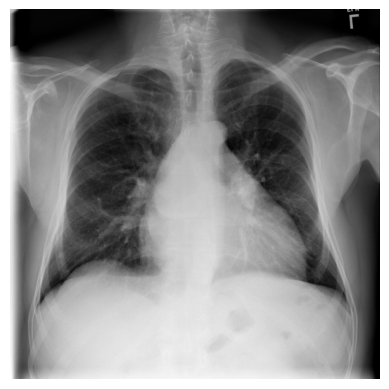

In [86]:
image_paths = glob.glob(os.path.join(DATA_DIR, 'images_*', 'images', '*.png'))
image_dict = {os.path.basename(path): path for path in image_paths}

sample_images = data['Image Index'].unique()
img_name = np.random.choice(sample_images, size=1, replace=False)[0]
img_path = image_dict.get(img_name)
img = Image.open(img_path)
data1 = data[data['Image Index'] == img_name]
# print(img)

# plt.figure(figsize=(6, 6))
# plt.imshow(img)
# plt.axis('off')
# plt.title(f"Findings: {', '.join(data1['Finding Label'].unique())}", fontsize=14)
# plt.show()


img = torchvision.io.decode_image(image_dict.get("00000001_000.png"))
# print(img.shape)
img = img.permute(1,2,0)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()

## Creating the DataLoader

In [87]:
class NIH_dataset(Dataset):
    '''
    Custom dataset class for the NIH\n
    params:\n
    df: Pandas dataframe containing the data\n
    image_directories: list of directories in string containing the images\n
    transform: torchvision.transforms.transforms. DO NOT PASS transforms.to_tensor() here\n
    target_transform: Not used here\n
    '''
    def __init__(self, df: pd.DataFrame, image_directories: list[str], transform: torchvision.transforms=None, target_transform=None):
        self.df = df
        self.image_dir = image_directories
        self.transform = transform
        self.image_to_path = {os.path.basename(path): path for path in self.image_dir}

    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.df)

    def __getitem__(self, idx: int):
        img_path = self.image_to_path.get(self.df.loc[idx, 'Image Index'])
        label: str = self.df.loc[idx, 'Finding Label']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label #returns img as tensor matrix, label as string


# Loading the parameters and dataloaders

In [ ]:
# Getting the image paths
image_paths = glob.glob(os.path.join(DATA_DIR, 'images_*', 'images', '*.png'))

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 50
learning_rate = 0.00075
batch_size = 2048
test_split_size = 0.001
train_size = 0.8
# num_of_workers = 16

# Defining the model, loss function and optimizer
weights = models.ResNet50_Weights.DEFAULT # Pretrained weights
model = models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15) # Change the output layer to 15 classes
model = model.to(device) # Move the model to the device

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Try different transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=30),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
    
])

#splitting the dataset
train_df, test_df = train_test_split(data,test_size=test_split_size,train_size=train_size)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_dataset = NIH_dataset(df=train_df, image_directories=image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# image_to_path = {os.path.basename(path): path for path in IMAGE_DIR}
# print(image_to_path.get(train_df.loc[85178, 'Image Index']))


# Metrics class

In [ ]:
# Class for metrics
class Metrics:
    def __init__(self):
        # Lists for storing the metrics
        self.y_true = None
        self.y_pred = None
        self.losses = []
        self.accuracy = []
        self.precision = []
        self.recall = []
        self.f1 = []
        self.roc_auc = []
        self.tn, self.fp, self.fn, self.tp = [], [], [], []
    
    def compute(self, y_true: torch.tensor, y_pred: torch.tensor, loss: torch.tensor = None):
        self.y_true = y_true
        self.y_pred = y_pred
        if loss:
            self._compute(loss)
        else:
            self._compute()
    
    def _compute(self, loss: torch.tensor = None):
        # Accuracy
        self.accuracy.append(accuracy_score(self.y_true, self.y_pred))
        # Precision
        self.precision.append(precision_score(self.y_true, self.y_pred, average='macro', zero_division=0))
        # Recall
        self.recall.append(recall_score(self.y_true, self.y_pred, average='macro', zero_division=0))
        # F1 Score
        self.f1.append(f1_score(self.y_true, self.y_pred, average='macro', zero_division=0))
        # ROC AUC
        # self.roc_auc.append(roc_auc_score(self.y_true, self.y_pred, average='macro', multi_class="ovo"))
        # Confusion Matrix
        conf_matrices = multilabel_confusion_matrix(self.y_true, self.y_pred)
        conf_matrix = conf_matrices.sum(axis=0)
        tn, fp, fn, tp = conf_matrix.ravel()
        self.tn.append(tn)
        self.fp.append(fp)
        self.fn.append(fn)
        self.tp.append(tp)
        self.losses.append(loss.item()) if loss else None

    def __str__(self):
        return f"""            Final loss: {self.losses[-1]:.4f}
            Final accuracy: {self.accuracy[-1]:.4f}
            Final precision: {self.precision[-1]:.4f}
            Final recall: {self.recall[-1]:.4f}
            Final f1: {self.f1[-1]:.4f}"""
            # Final roc_auc: {self.roc_auc[-1]:.4f}
    
    def plot(self, save: bool = False, path: str = ".", show: bool = False):
        fig, ax = plt.subplots(2, 2, figsize=(16, 12))
        # Loss
        ax[0, 0].plot(self.losses)
        ax[0, 0].set_title('Loss')
        # Accuracy
        ax[0, 1].plot(self.accuracy)
        ax[0, 1].set_title('Accuracy')
        # Precision
        ax[1, 0].plot(self.precision)
        ax[1, 0].set_title('Precision')
        # Recall
        ax[1, 1].plot(self.recall)
        ax[1, 1].set_title('Recall')

        if show:
            plt.show()
        if save:
            plt.savefig(f"{path}/metrics.png")
        

# Training the model

100%|██████████| 40/40 [02:30<00:00,  3.76s/it]


            Final loss: 0.0430
            Final accuracy: 0.9769
            Final precision: 0.9964
            Final recall: 0.9886
            Final f1: 0.9919


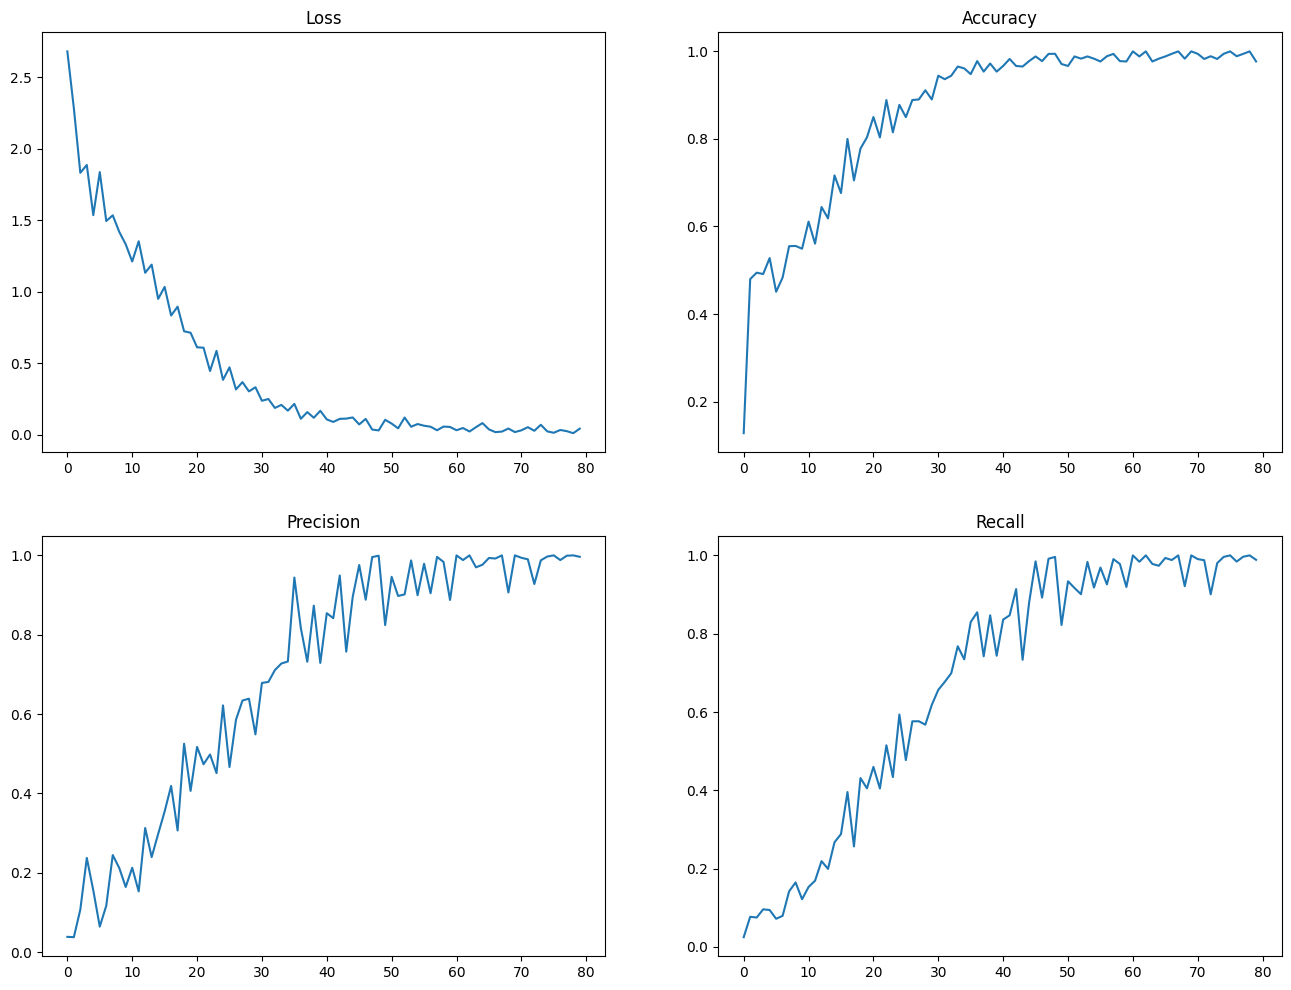

In [90]:
def train(epochs: int, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer) -> tuple[torch.nn.Module, Metrics]:
    metrics = Metrics()
    for epoch in tqdm.tqdm(range(epochs)):
        for inputs, labels in tqdm.tqdm(dataloader):
            # Move input and label tensors to the device
            inputs = inputs.to(device)
            labels = torch.tensor([disease_to_number[label] for label in labels]).to(device)
            
            # Zero out the optimizer
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            max_logits, out_lab = torch.max(outputs, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Metrics
            metrics.compute(labels.cpu(), out_lab.cpu(), loss.cpu())

            # Backward pass
            loss.backward()
            optimizer.step()

    return model, metrics

resnet_trained, metrics = train(epochs, model, train_loader, criterion, optimizer)
print(metrics)
metrics.plot(save=True)

# Clearing cache and running garbage collector

In [91]:
# Empty GPU
import gc

try:
    del model
except:
    pass
try:
    del resnet_trained
except:
    pass
try:
    del metrics
except:
    pass

gc.collect()
torch.cuda.empty_cache()


# Save the model

In [ ]:
# Save the model
torch.save(resnet_trained, f"{model.__class__.__name__}_{epochs} epochs_{learning_rate} lr_{batch_size} batch_size.pth")